In [2]:
import warnings; warnings.simplefilter('ignore', FutureWarning)
import numpy as np
import time
import os
from copy import deepcopy
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import (permutation_test_score, learning_curve, LeaveOneGroupOut,
                                     KFold, cross_val_score, cross_val_predict, cross_validate,
                                     train_test_split)
from sklearn.utils import parallel_backend
from sklearn.base import clone
import pickle
from joblib.parallel import Parallel, delayed
from permutation_helpers import *
from simulate import simulate

# Dask imports
from dask.distributed import progress, Client, wait, Future
from dask_jobqueue import SGECluster
# from dask_jobqueue import SLURMCluster

# helpful functions for debugging and monitoring Dask jobs
def get_exceptions(futures: Iterable[Future], params: Iterable = None) -> pd.DataFrame:
    """
    Given a list of Dask futures and a list of parameters,
    return a DataFrame of exceptions.
    """
    if params is None:
        params = range(len(futures))
    exceptions = []
    for i, (param, future) in enumerate(zip(params, futures)):
        if future.status == "error":
            exceptions.append(pd.Series(
                {
                    "param": param,
                    "exception": repr(future.exception()),
                    "traceback_obj": future.traceback(),
                }
            ))
    if not len(exceptions):
        raise Exception("None of the given futures resulted in exceptions")
    exceptions = pd.concat(exceptions, axis=1).T
    exceptions.set_index("param", inplace=True)
    return exceptions

import traceback
def print_traceback(error_df, index):
    traceback.print_tb(error_df.loc[index, "traceback_obj"])

In [54]:
client.shutdown()

In [2]:
metric = "brier_score"
testsize = pd.read_pickle(f"testsize_pval_{metric}.pkl")
# samplesize = pd.read_pickle(f"samplesize_pval_{metric}.pkl")
# nfeats = pd.read_pickle(f"nfeats_pval_{metric}.pkl")
# ratio = pd.read_pickle(f"ratio_pval_{metric}.pkl")

In [5]:
testsize = pd.read_pickle("testsize.pkl")

In [9]:
cluster = SGECluster( # or replace with SLURMCluster or other
    cores = 1, # cores per job
    memory = "2GB", # memory per job
    processes = 1,
    queue = "short.q",
    job_extra = ["-t 1-120"],
    log_directory = os.path.join(os.environ["HOME"], "logs/"),
    local_directory = os.path.join(os.environ["HOME"], "dask-worker-space/"),
    walltime = "03:59:00",
    name = "permutations-{$SGE_TASK_ID}",
)

client = Client(cluster)
cluster.scale(n=1)
# cluster.adapt(maximum_jobs=250) # 256 is the user limit on wharton's HPC

In [4]:
maha_values = np.linspace(0., 1.5, 5)

def set_params(maha, save=True): 
    ### shared parameters
    class_params = {
            "C":np.logspace(np.log10(1e-4), np.log10(1e5), 8),
            "class_weight":"balanced"
        }
    permutation_params = {
            "n_permutations": 5000
        }
    sim_params = {
        "n_sim": 500,
        }
    
    data_dir = os.path.join(os.environ["HOME"], "data")
    results_dir = os.path.join(data_dir, "sim_results", f"maha_{maha:.1f}")
    file_params = {
        "save": True,
        "results_dir": results_dir
    }
    data_gen_params = {
        "maha": maha,
        "psi_diag": 1.0,
        "psi_offdiag": 0.,
        "ddof": 150,
        "n_samples":1000,
        "n_feats": 10,
        "class_ratio": 0.5,
    }
    ## default parameters for simulations
    default_params ={
        "sim" : deepcopy(sim_params),
        "data_gen" : deepcopy(data_gen_params),
        "classif" : deepcopy(class_params),
        "perm" : deepcopy(permutation_params),
        "file" : deepcopy(file_params)
    }

    ## set up parameters for specific simulations
    ## use default parameters and update the ones that need to be changed
    ## for each simulation, we will vary one parameter at a time and remove 
    ## the corresponding key from the data_gen dictionary to avoid conflicts

    samplesize_params = deepcopy(default_params)
    samplesize_params["sim"]["parameter_range"] = np.logspace(2, 5, 5).astype(int)
    samplesize_params["data_gen"].pop("n_samples")

    nfeats_params = deepcopy(default_params)
    nfeats_params["sim"]["parameter_range"] = np.logspace(1, 10, 5, base=2).astype(int)
    nfeats_params["data_gen"].pop("n_feats")

    ratio_params = deepcopy(default_params)
    ratio_params["sim"]["parameter_range"] = np.logspace(np.log10(.01), np.log10(.5), 5)
    ratio_params["data_gen"].pop("class_ratio")

    testsize_params = deepcopy(default_params)
    testsize_params["sim"]["parameter_range"] = np.logspace(np.log10(.01), np.log10(.5), 5)
    if save:
        pickle.dump(samplesize_params, 
                    open(f"settings/samplesize_params_maha_{data_gen_params['maha']:.1f}.pkl", "wb"))
        pickle.dump(nfeats_params,
                    open(f"settings/nfeats_params_maha_{data_gen_params['maha']:.1f}.pkl", "wb"))
        pickle.dump(ratio_params,
                    open(f"settings/ratio_params_maha_{data_gen_params['maha']:.1f}.pkl", "wb"))
        pickle.dump(testsize_params,
                    open(f"settings/testsize_params_maha_{data_gen_params['maha']:.1f}.pkl", "wb"))
    return samplesize_params, nfeats_params, ratio_params, testsize_params, default_params


for maha in maha_values:
    data_dir = os.path.join(os.environ["HOME"], "data")
    results_dir = os.path.join(data_dir, "sim_results", f"maha_{maha:.1f}")
    ## set up directories for saving results
    ## results are separated by the the underlying probability distributions (and their mahalanobis distance)
    os.makedirs(results_dir, exist_ok=True) 

In [32]:
from scipy.stats import chi2_contingency

for maha in maha_values:
    samplesize_params, nfeats_params, ratio_params, testsize_params, _ = set_params(maha, save=False)
    @simulate(**samplesize_params["sim"])
    def simulate_samplesize(param=None, seed=None, simno=None, settings=samplesize_params):
        settings = deepcopy(settings)
        ## Simulate dataset
        X, y = random_data_gen(n_samples=param, seed=seed, **settings["data_gen"])
        ## Split into train-test set
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, shuffle=True
        )
        ## Simulate validation set
        X_val, y_val = random_data_gen(n_samples=1000, seed=None, **settings["data_gen"])
        ## iterate over possible penalty params
        max_AUC = 0
        best_estimator = None
        for C in settings["classif"].pop("C"):
            estimator = LogisticRegression(**settings["classif"], C=C)
            estimator.fit(X=X_train, y=y_train)
            y_pred = estimator.predict_proba(X_val)[:, 1]
            AUC = roc_auc_score(y_score=y_pred, y_true=y_val)
            if AUC >= max_AUC:
                max_AUC = AUC
                best_estimator = estimator
        ## use model with tuned penalty
        y_pred = best_estimator.predict_proba(X_test)[:, 1]
        ## permutations
        contingency_table = pd.crosstab(y_test, y_pred.round())
        chi2, p, _, _ = chi2_contingency(contingency_table)
        # if settings["file"]["save"]:
        #     pickle.dump(
        #         (score, permutation_scores), 
        #         open(os.path.join(settings["file"]["results_dir"], f"post_samplesize_{param:.4f}_simno_{simno:05}.pkl"), "wb"))
        return simno, chi2, p


    @simulate(**testsize_params["sim"])
    def simulate_testsize(param=None, seed=None, simno=None, settings=testsize_params):
        settings = deepcopy(settings)
        ## Simulate dataset
        X, y = random_data_gen(seed=seed, **settings["data_gen"])
        ## Split into train-test set
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=param, shuffle=True
        )
        ## Simulate validation set
        X_val, y_val = random_data_gen(seed=None, **settings["data_gen"])
        ## iterate over possible penalty params
        max_AUC = 0
        best_estimator = None
        for C in settings["classif"].pop("C"):
            estimator = LogisticRegression(**settings["classif"], C=C)
            estimator.fit(X=X_train, y=y_train)
            y_pred = estimator.predict_proba(X_val)[:, 1]
            AUC = roc_auc_score(y_score=y_pred, y_true=y_val)
            if AUC >= max_AUC:
                max_AUC = AUC
                best_estimator = estimator
        ## use model with tuned penalty
        y_pred = best_estimator.predict_proba(X_test)[:, 1]
        ## permutations
        n_permutations = settings["perm"]["n_permutations"]
        contingency_table = pd.crosstab(y_test, y_pred.round())
        chi2, p, _, _ = chi2_contingency(contingency_table)
        # if settings["file"]["save"]:
        #     pickle.dump(
        #         (score, permutation_scores), 
        #         open(os.path.join(settings["file"]["results_dir"], f"post_testsize_{param:.4f}_simno_{simno:05}.pkl"), "wb"))
        return simno, chi2, p


    @simulate(**nfeats_params["sim"])
    def simulate_nfeats(param=None, seed=None, simno=None, settings=nfeats_params):
        settings = deepcopy(settings)
        ## Simulate dataset
        X, y = random_data_gen(n_feats=param, seed=seed, **settings["data_gen"])
        ## Split into train-test set
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, shuffle=True
        )
        ## Simulate validation set
        X_val, y_val = random_data_gen(n_feats=param, seed=None, **settings["data_gen"])
        ## iterate over possible penalty params
        max_AUC = 0
        best_estimator = None
        for C in settings["classif"].pop("C"):
            estimator = LogisticRegression(**settings["classif"], C=C)
            estimator.fit(X=X_train, y=y_train)
            y_pred = estimator.predict_proba(X_val)[:, 1]
            AUC = roc_auc_score(y_score=y_pred, y_true=y_val)
            if AUC >= max_AUC:
                max_AUC = AUC
                best_estimator = estimator
        ## use model with tuned penalty
        y_pred = best_estimator.predict_proba(X_test)[:, 1]
        ## permutations
        contingency_table = pd.crosstab(y_test, y_pred.round())
        chi2, p, _, _ = chi2_contingency(contingency_table)
        # if settings["file"]["save"]:
        #     pickle.dump(
        #         (score, permutation_scores), 
        #         open(os.path.join(settings["file"]["results_dir"], f"post_nfeats_{param:.4f}_simno_{simno:05}.pkl"), "wb"))
        return simno, chi2, p


    @simulate(**ratio_params["sim"])
    def simulate_ratio(param=None, seed=None, simno=None, settings=ratio_params):
        settings = deepcopy(settings)
        ## Simulate dataset
        X, y = random_data_gen(class_ratio=param, seed=seed, **settings["data_gen"])
        ## Split into train-test set
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, shuffle=True
        )
        ## Simulate validation set, same as original dataset
        X_val, y_val = random_data_gen(class_ratio=param, seed=None, **settings["data_gen"])
        ## iterate over possible penalty params
        max_AUC = 0
        best_estimator = None
        for C in settings["classif"].pop("C"):
            estimator = LogisticRegression(**settings["classif"], C=C)
            estimator.fit(X=X_train, y=y_train)
            y_pred = estimator.predict_proba(X_val)[:, 1]
            AUC = roc_auc_score(y_score=y_pred, y_true=y_val)
            if AUC >= max_AUC:
                max_AUC = AUC
                best_estimator = estimator
        ## use model with tuned penalty
        y_pred = best_estimator.predict_proba(X_test)[:, 1]
        ## permutations
        contingency_table = pd.crosstab(y_test, y_pred.round())
        chi2, p, _, _ = chi2_contingency(contingency_table)
        # save with pickle
        # if settings["file"]["save"]:
        #     pickle.dump(
        #         (score, permutation_scores), 
        #         open(os.path.join(settings["file"]["results_dir"], f"post_ratio_{param:.4f}_simno_{simno:05}.pkl"), "wb"))
        return simno, chi2, p
    
    testsize_futures, testsize_gather = simulate_testsize()
    samplesize_futures, samplesize_gather = simulate_samplesize()
    nfeats_futures, nfeats_gather = simulate_nfeats()
    ratio_futures, ratio_gather = simulate_ratio()
    contingency_testsize = testsize_gather(testsize_futures)
    pd.DataFrame(contingency_testsize).melt(var_name="param").to_pickle(f"contingency_testsize_maha_{maha:.1f}_.pkl")
    contingency_samplesize = samplesize_gather(samplesize_futures)
    pd.DataFrame(contingency_samplesize).melt(var_name="param").to_pickle(f"contingency_samplesize_maha_{maha:.1f}_.pkl")
    contingency_nfeats = nfeats_gather(nfeats_futures)
    pd.DataFrame(contingency_nfeats).melt(var_name="param").to_pickle(f"contingency_nfeats_maha_{maha:.1f}_.pkl")
    contingency_ratio = ratio_gather(ratio_futures)
    pd.DataFrame(contingency_ratio).melt(var_name="param").to_pickle(f"contingency_ratio_maha_{maha:.1f}_.pkl")
    # wait for all futures to complete
    wait(testsize_futures + samplesize_futures + nfeats_futures + ratio_futures)
    # give cluster time to clean up before next iteration
    time.sleep(60)

Running 500 simulations
Using dask client at http://10.152.33.159:8787/status
Running 500 simulations
Using dask client at http://10.152.33.159:8787/status
Running 500 simulations
Using dask client at http://10.152.33.159:8787/status
Running 500 simulations
Using dask client at http://10.152.33.159:8787/status
2500 parallel jobs
2500 parallel jobs
2500 parallel jobs
2500 parallel jobs
Running 500 simulations
Using dask client at http://10.152.33.159:8787/status
Running 500 simulations
Using dask client at http://10.152.33.159:8787/status
Running 500 simulations
Using dask client at http://10.152.33.159:8787/status
Running 500 simulations
Using dask client at http://10.152.33.159:8787/status
2500 parallel jobs
2500 parallel jobs
2500 parallel jobs
2500 parallel jobs
Running 500 simulations
Using dask client at http://10.152.33.159:8787/status
Running 500 simulations
Using dask client at http://10.152.33.159:8787/status
Running 500 simulations
Using dask client at http://10.152.33.159:87

In [30]:
client.cancel(testsize_futures + samplesize_futures + nfeats_futures + ratio_futures)

In [5]:
# read in the results
contingency_testsize = pd.DataFrame()
contingency_samplesize = pd.DataFrame()
contingency_nfeats = pd.DataFrame()
contingency_ratio = pd.DataFrame()

# merge across maha values
for maha in maha_values:
    df = pd.read_pickle(f"contingency_testsize_maha_{maha:.1f}_.pkl")
    df[["simno", "chi2", "pval"]] = df["value"].apply(pd.Series)
    df["d"] = maha
    contingency_testsize = pd.concat([contingency_testsize, df], ignore_index=True)
    df = pd.read_pickle(f"contingency_samplesize_maha_{maha:.1f}_.pkl")
    df[["simno", "chi2", "pval"]] = df["value"].apply(pd.Series)
    df["d"] = maha
    contingency_samplesize = pd.concat([contingency_samplesize, df], ignore_index=True)
    df = pd.read_pickle(f"contingency_nfeats_maha_{maha:.1f}_.pkl")
    df[["simno", "chi2", "pval"]] = df["value"].apply(pd.Series)
    df["d"] = maha
    contingency_nfeats = pd.concat([contingency_nfeats, df], ignore_index=True)
    df = pd.read_pickle(f"contingency_ratio_maha_{maha:.1f}_.pkl")
    df[["simno", "chi2", "pval"]] = df["value"].apply(pd.Series)
    df["d"] = maha
    contingency_ratio = pd.concat([contingency_ratio, df], ignore_index=True)

contingency_ratio.drop(columns="value", inplace=True)
contingency_ratio["test"] = "contingency"
contingency_nfeats.drop(columns="value", inplace=True)
contingency_nfeats["test"] = "contingency"
contingency_samplesize.drop(columns="value", inplace=True)
contingency_samplesize["test"] = "contingency"
contingency_testsize.drop(columns="value", inplace=True)
contingency_testsize["test"] = "contingency"

In [6]:
metric = "accuracy"
testsize = pd.read_pickle(f"testsize_pval_{metric}.pkl")
samplesize = pd.read_pickle(f"samplesize_pval_{metric}.pkl")
nfeats = pd.read_pickle(f"nfeats_pval_{metric}.pkl")
ratio = pd.read_pickle(f"ratio_pval_{metric}.pkl")

testsize = pd.concat([contingency_testsize, testsize], ignore_index=True)
testsize["positive"] = testsize["pval"] <= 0.05
samplesize = pd.concat([contingency_samplesize, samplesize], ignore_index=True)
samplesize["positive"] = samplesize["pval"] <= 0.05
nfeats = pd.concat([contingency_nfeats, nfeats], ignore_index=True)
nfeats["positive"] = nfeats["pval"] <= 0.05
ratio = pd.concat([contingency_ratio, ratio], ignore_index=True)
ratio["positive"] = ratio["pval"] <= 0.05

In [7]:
import warnings; warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import (LogLocator, NullLocator, 
                                NullFormatter, LogFormatterMathtext, 
                                ScalarFormatter, StrMethodFormatter)
import math
plt.rcParams["pdf.fonttype"]=42
plt.rcParams["font.size"]=14
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["savefig.transparent"] = False
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams["axes.spines.right"]=False
plt.rcParams["axes.spines.top"]=False
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.1
plt.rcParams["axes.labelsize"] = 16

import seaborn as sns
import json

wharton_colors = json.load(open("wharton-colors-distinct.json", "r"))
wharton_pal = sns.color_palette(wharton_colors.values(), n_colors=len(wharton_colors))
sequential_wharton = sns.color_palette(
    f"blend:{wharton_colors['College Gray']},{wharton_colors['Wharton Blue']}",
    as_cmap=True
    )
# set matplotlib color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=wharton_pal)



import numpy as np
import pandas as pd
import os
import pickle

from permutation_helpers import random_data_gen

from scipy.stats import norm
def auc_from_maha(maha_dist: float):
    # source: https://en.wikipedia.org/wiki/Sensitivity_index#RMS_sd_discriminability_index
    auc = norm.cdf(maha_dist / np.sqrt(2))
    return auc

maha_values = np.linspace(0., 1.5, 5)

Text(0.5, 0.01, 'Mahalanobis Distance')

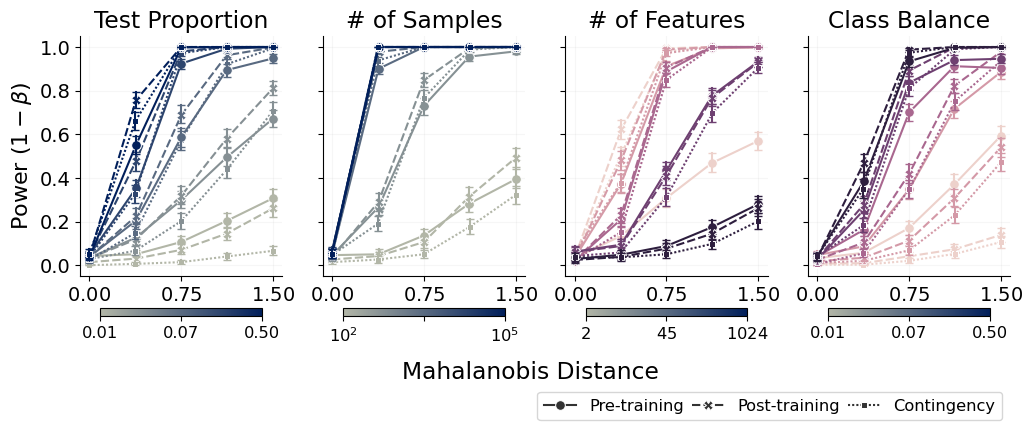

In [12]:
sequential_wharton = sns.color_palette(
    f"blend:{wharton_colors['College Gray']},{wharton_colors['Wharton Blue']}",
    as_cmap=True,
)

# subplots with shared y axis
fig, ax = plt.subplots(1, 4, figsize=(12, 4), sharey=True, sharex=True)
ax = ax.ravel()
# test/train split
sns.lineplot(
    data=testsize,
    x="d",
    y="positive",
    hue="param",
    hue_norm=LogNorm(),
    style="test",
    style_order=["pre", "post", "contingency"],
    markers=True,
    markersize=7,
    err_style="bars",
    err_kws={"capsize": 3},
    palette=sequential_wharton,
    ax=ax[0],
)
ax[0].set_xticks(np.linspace(0, 1.5, 3))
mappable = plt.cm.ScalarMappable(cmap=sequential_wharton, norm=LogNorm())
mappable.set_array(testsize["param"].unique())
cbar = plt.colorbar(mappable, ax=ax[0], orientation="horizontal", shrink=0.8, pad=0.1)
minor_locator = NullLocator()
cbar.ax.xaxis.set_minor_locator(minor_locator)
ticks = np.logspace(
    np.log10(testsize["param"].min()), np.log10(testsize["param"].max()), num=3
)
cbar.set_ticks(ticks)
cbar.ax.tick_params(labelsize="small")
cbar.ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.2f}"))

# major_formatter = LogFormatterMathtext(base=10, labelOnlyBase=False)
# cbar.ax.xaxis.set_major_formatter(major_formatter)
# use ticker

# number of samples
sns.lineplot(
    data=samplesize,
    x="d",
    y="positive",
    hue="param",
    hue_norm=LogNorm(),
    style="test",
    style_order=["pre", "post", "contingency"],
    markers=True,
    markersize=7,
    err_style="bars",
    err_kws={"capsize": 3},
    palette=sequential_wharton,
    ax=ax[1],
)
mappable = plt.cm.ScalarMappable(cmap=sequential_wharton, norm=LogNorm())
mappable.set_array(samplesize["param"].unique())
cbar = plt.colorbar(mappable, ax=ax[1], orientation="horizontal", shrink=0.8, pad=0.1)
minor_locator = NullLocator()
cbar.ax.xaxis.set_minor_locator(minor_locator)
ticks = np.logspace(
    np.log10(samplesize["param"].min()), np.log10(samplesize["param"].max()), num=3
)
cbar.set_ticks(ticks)
cbar.ax.tick_params(labelsize="small")
ax[1].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))

# number of features
sns.lineplot(
    data=nfeats,
    x="d",
    y="positive",
    hue="param",
    hue_norm=LogNorm(),
    style="test",
    style_order=["pre", "post", "contingency"],
    markers=True,
    markersize=7,
    err_style="bars",
    err_kws={"capsize": 3},
    ax=ax[2],
)
mappable = plt.cm.ScalarMappable(cmap=sequential_wharton, norm=LogNorm())
mappable.set_array(nfeats["param"].unique())
cbar = plt.colorbar(mappable, ax=ax[2], orientation="horizontal", shrink=0.8, pad=0.1)
cbar.ax.xaxis.set_minor_locator(minor_locator)
ticks = np.logspace(
    np.log10(nfeats["param"].min()), np.log10(nfeats["param"].max()), num=3
)
cbar.set_ticks(ticks)
cbar.ax.tick_params(labelsize="small")
cbar.ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))

# class balance ratio
sns.lineplot(
    data=ratio,
    x="d",
    y="positive",
    hue="param",
    hue_norm=LogNorm(),
    style="test",
    style_order=["pre", "post", "contingency"],
    markers=True,
    markersize=7,
    err_style="bars",
    err_kws={"capsize": 3},
    ax=ax[3],
)
mappable = plt.cm.ScalarMappable(cmap=sequential_wharton, norm=LogNorm())
mappable.set_array(ratio["param"].unique())
cbar = plt.colorbar(mappable, ax=ax[3], orientation="horizontal", shrink=0.8, pad=0.1)
minor_locator = NullLocator()
cbar.ax.xaxis.set_minor_locator(minor_locator)
ticks = np.logspace(
    np.log10(ratio["param"].min()), np.log10(ratio["param"].max()), num=3
)
cbar.set_ticks(ticks)
cbar.ax.tick_params(labelsize="small")
cbar.ax.xaxis.set_major_formatter(StrMethodFormatter("{x:.2f}"))

# set titles and labels

titles = [
    "Test Proportion",
    "# of Samples",
    "# of Features",
    "Class Balance",
]
for i, title in enumerate(titles):
    ax[i].set_xlabel(None)
    ax[i].set_ylabel(r"Power ($1-\beta$)")
    handles, labels = ax[i].get_legend_handles_labels()
    # put legend above the plot, use title
    # ax[i].legend(
    #     title=title,
    #     handles=handles[1:-3],
    #     labels=labels[1:-3],
    #     loc="lower center",
    #     bbox_to_anchor=(0.5, 1),
    #     # small font
    #     fontsize="x-small",
    #     ncols = 2,
    #     frameon=False,
    # )
    # remove legend from plot, set title
    ax[i].set_title(title)
    ax[i].get_legend().remove()
# plt.tight_layout()

sup_handles, sup_labels = ax[0].get_legend_handles_labels()
fig.legend(
    handles=sup_handles[-3:],
    labels=["Pre-training", "Post-training", "Contingency"],
    loc="lower right",
    bbox_to_anchor=(0.9, -0.1),
    ncols=3,
    fontsize="small",
    columnspacing=0.5,
)
# add a single x and y label
plt.subplots_adjust(wspace=0.2, bottom=0.08)
fig.supxlabel(r"Mahalanobis Distance")

# make sure top of the figure is not cut off
# plt.savefig(f"figures/power-comparison-{metric}.pdf", bbox_inches="tight")

## CV results

In [1]:
import os
import pickle
filename = os.path.join(os.environ["HOME"], "data/sim_results/maha_0.0/cv_post_accuracy_samplesize_1000.0000_simno_00000.pkl")



In [2]:
import pandas as pd
maha = 0.0
pd.DataFrame([cv_results, cv_results])


,score,null_scores,pvalue
0,0.495,"[0.49700000000000005, 0.507, 0.466999999999999...",0.631369
1,0.495,"[0.49700000000000005, 0.507, 0.466999999999999...",0.631369


In [4]:
import glob
all_cv_results = []
for maha in maha_values:
    for path in glob.glob(os.path.join(os.environ["HOME"], f"data/sim_results/maha_{maha:.1f}")):
        cv_results = pickle.load(open(path, "rb"))
        cv_results["maha"] = maha
        all_cv_results.append(cv_results)
pd.DataFrame(all_cv_results)


IsADirectoryError: [Errno 21] Is a directory: '/home/stat/jrudoler/data/sim_results/maha_1.5'